In [1]:
import math
import numpy as np
from datetime import datetime, timedelta, date
import time
import xarray as xr
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
def speedstats(dsspeed, percent=False):
    bins=list(range(0,int(dsspeed["speed"].max())+2))
    sg = dsspeed.groupby_bins("speed",bins)
    speedcounts = sg.count(...)["speed"]
    speedlabelsdict={}
    for k in sg.groups:
        speedlabelsdict[k.left]=k
    speedlabels=[]    
    for k in sorted(speedlabelsdict):
        speedlabels.append("%s"%speedlabelsdict[k])
    if percent:
        alldscount = dsspeed["speed"].count().item(0)
        speedcounts = speedcounts/alldscount
    return speedlabels, speedcounts

In [3]:
def directionstats(dsdir, percent=False):
    dirlabels = ["N","NE", "E", "SE", "S", "SW", "W", "NW"]
    dirgroup = dsdir.groupby("direction")
    dircounts = dirgroup.count(...)["angle"]
    if percent:
        alldscount = dsdir["speed"].count().item(0)
        dircounts = dircounts/alldscount
    return dirlabels, dircounts

In [124]:
ds = xr.load_dataset("/home/aapostolakis/Documents/preprocess/1990_2020_speed_dir.nc")

In [125]:
dscell = ds.sel(latitude=slice(37.95,37.85), longitude=slice(23.85, 23.95))

In [126]:
dscell

<xarray.Dataset>
Dimensions:     (latitude: 1, longitude: 1, step: 24, time: 6512)
Coordinates:
    valid_time  (time, step) datetime64[ns] 1990-03-31T01:00:00 ... 2020-06-01
  * time        (time) datetime64[ns] 1990-03-31 1990-04-01 ... 2020-05-31
  * step        (step) timedelta64[ns] 01:00:00 02:00:00 ... 1 days 00:00:00
  * latitude    (latitude) float64 37.9
  * longitude   (longitude) float64 23.9
    number      int32 0
    surface     int32 0
Data variables:
    u10         (time, step, latitude, longitude) float32 nan nan ... 1.0353851
    v10         (time, step, latitude, longitude) float32 nan nan ... 0.37730408
    speed       (time, step, latitude, longitude) float32 nan nan ... 1.1019894
    angle       (time, step, latitude, longitude) float64 nan nan ... 250.0
    direction   (time, step, latitude, longitude) float64 nan nan ... 6.0 7.0
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2020-10-13T17:53:06 GRIB to CDM+CF via cfgrib-0....

<BarContainer object of 12 artists>

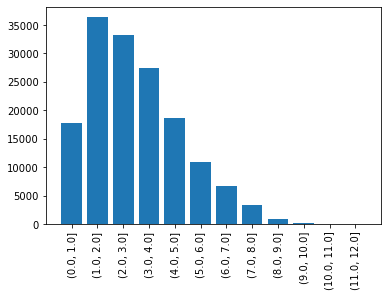

In [8]:
lab, speeds = speedstats(dscell)
plt.xticks(rotation=90)
plt.bar(lab,speeds)

<BarContainer object of 8 artists>

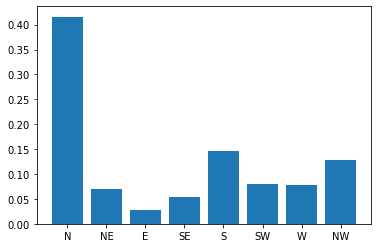

In [9]:
directions,dircounts = directionstats(dscell, percent=True)
plt.bar(directions,dircounts)

In [10]:
start="2010-01-01"
end="2020-12-31"
dstimerange=dscell.sel(time=slice(start, end))

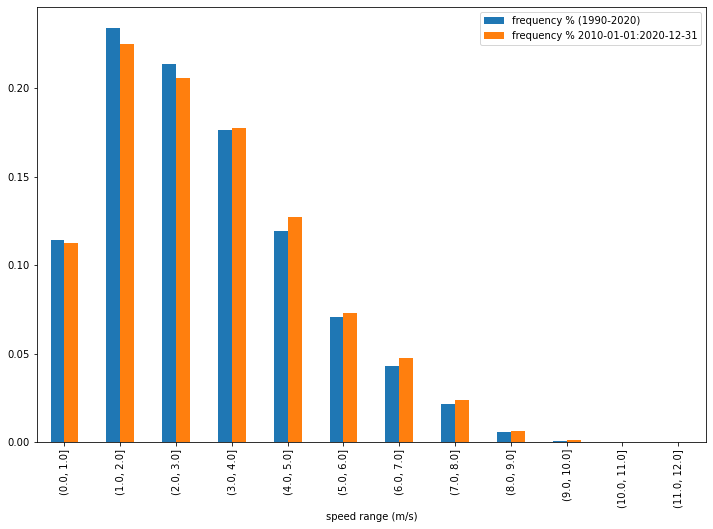

In [11]:
lab1, speeds1 = speedstats(dscell, percent=True)
lab2, speeds2 = speedstats(dstimerange, percent=True)
speeds2 = np.append(speeds2, np.zeros(len(speeds1)-len(speeds2), dtype=np.int8))
dfplt=pd.DataFrame({"speed range (m/s)":lab1, "frequency % (1990-2020)":speeds1, "frequency %% %s:%s"%(start,end):speeds2})
dfplt.plot.bar(x='speed range (m/s)',  figsize=(12,8), logy=False)

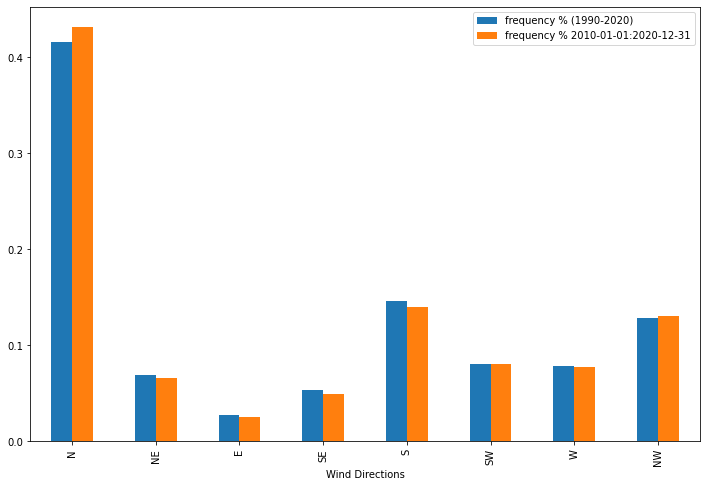

In [11]:
lab1, dirs1 = directionstats(dscell, percent=True)
lab2, dirs2 = directionstats(dstimerange, percent=True)
dfplt=pd.DataFrame({"Wind Directions":lab1, "frequency % (1990-2020)":dirs1, "frequency %% %s:%s"%(start,end):dirs2, })
dfplt.plot.bar(x="Wind Directions", figsize=(12,8))

In [18]:
dirlab=["N","NE", "E", "SE", "S", "SW", "W", "NW"]
allspeedlabels, allspeeds = speedstats(dscell, percent=True)
plotdata=[]
for i in range(1,len(dirlab)+1):
    onedirset=dscell.where(dscell.direction==i)
    l, dirspeeds = speedstats(onedirset, percent=True)
    dirspeeds = np.append(dirspeeds, np.zeros(len(allspeeds)-len(dirspeeds), dtype=np.int8))
    plotdata.append(dirspeeds)

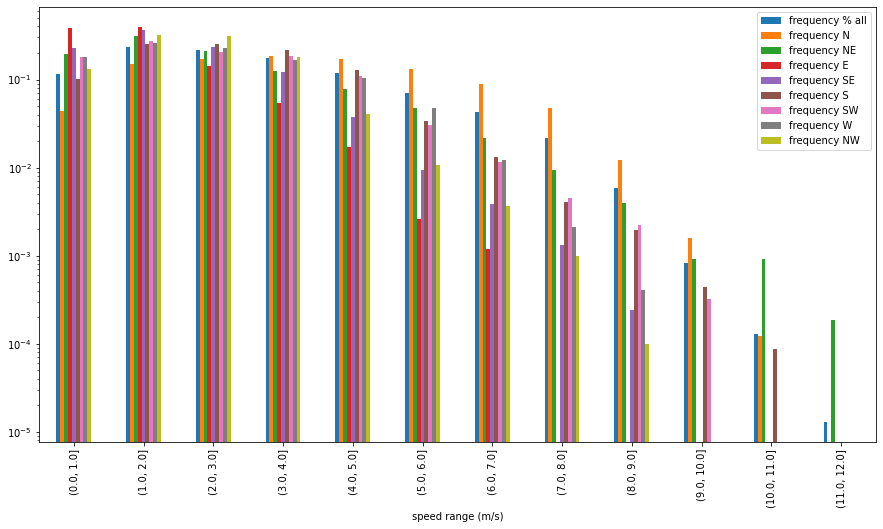

In [19]:
pddict={"speed range (m/s)":allspeedlabels, "frequency % all":allspeeds}
for i in range(0,len(dirlab)):
    pddict["frequency %s"%dirlab[i]]=plotdata[i]   
dfplt=pd.DataFrame(pddict)
dfplt.plot.bar(x='speed range (m/s)',  figsize=(15,8), logy=True)

In [20]:
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm

In [23]:
df = dscell.to_dataframe()

In [24]:
from windrose import plot_windrose

In [25]:
df_sd = df[['speed', 'angle']]

In [69]:
def wind_rose(df_sd):
    df_s = df_sd['speed']
    df_d = df_sd['direction']
    dirlabels = ["E", "N-E", "N", "N-W", "W", "S-W", "S", "S-E"]
    ax = WindroseAxes.from_ax(theta_labels=dirlabels)
    ax.bar(df_d,df_s,normed=True, opening=0.8, edgecolor='white')
    ax.set_legend()
def degToCompass(num):
    val=int((num/45))
    arr=["N","NE","E", "SE","S","SW","W","NW"]
    return arr[(val % 8)]

In [26]:
df_sd = df_sd.reset_index()[['speed', 'angle']].dropna().rename(columns = {'angle': 'direction'})

In [71]:
df_sd['dir_name'] = df_sd['direction'].apply(lambda x: degToCompass(x))

In [98]:
df_sd.speed.max()

11.215214

# Plots for each speed category

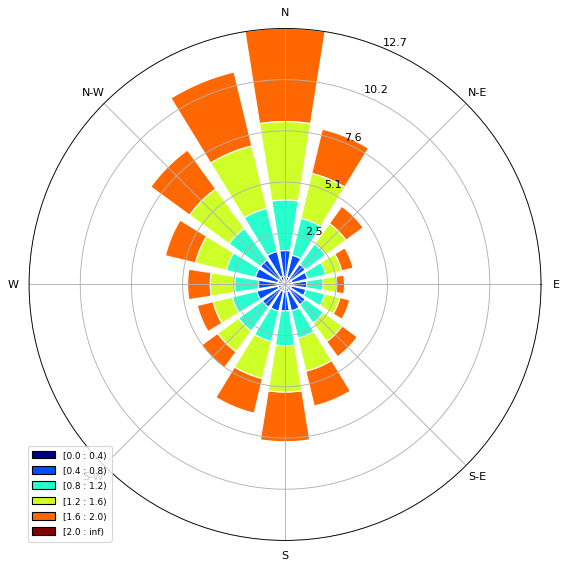

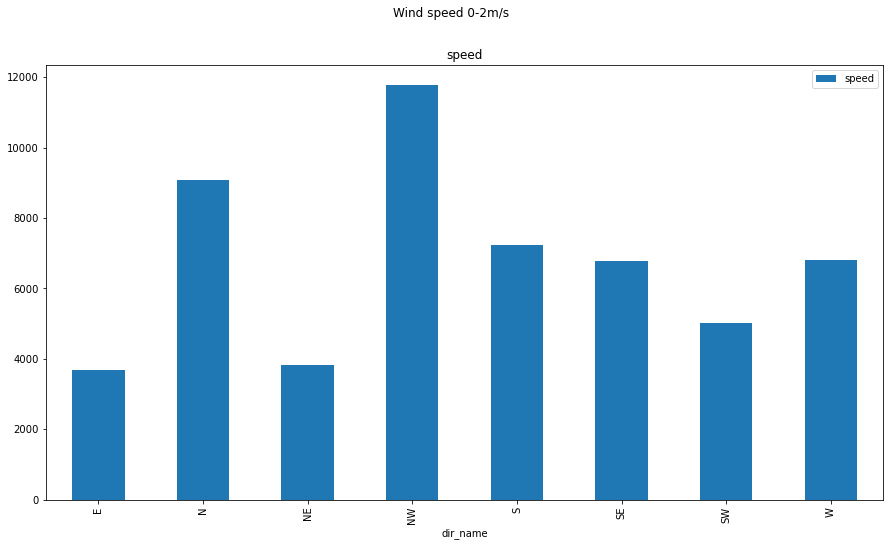

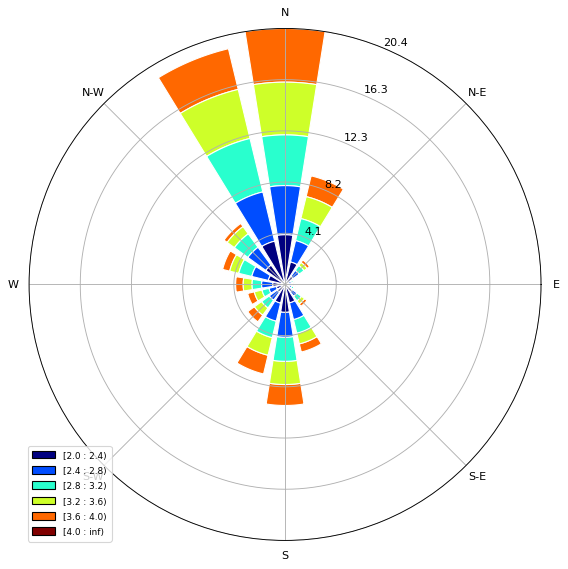

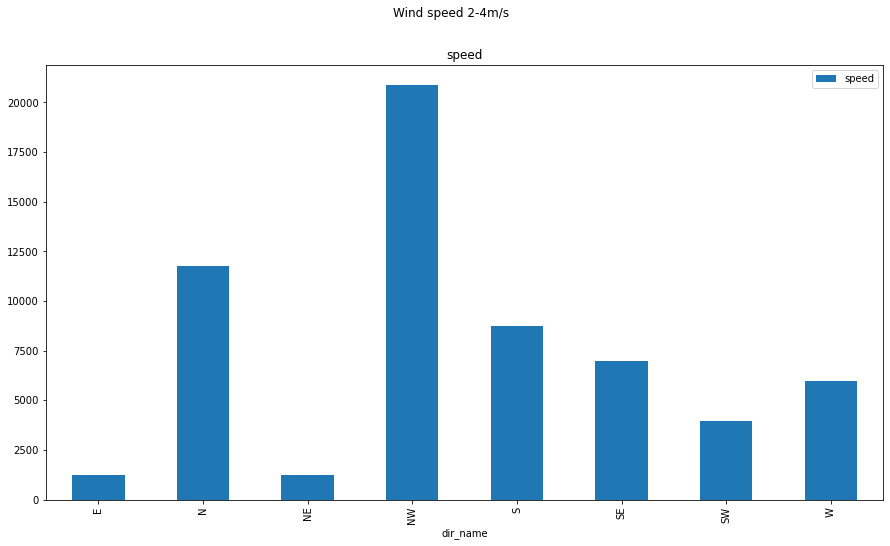

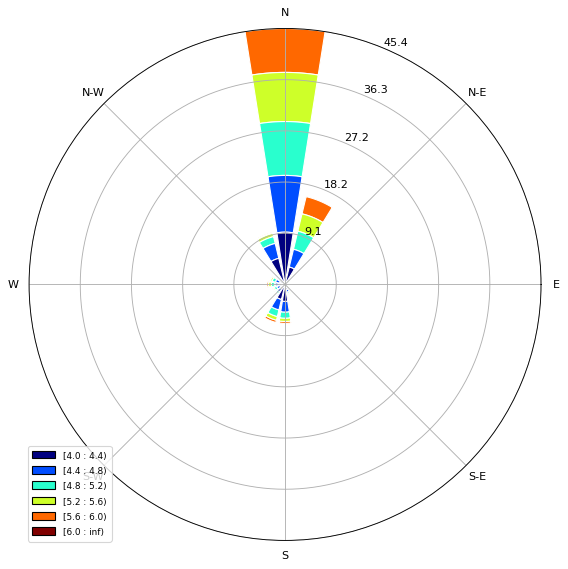

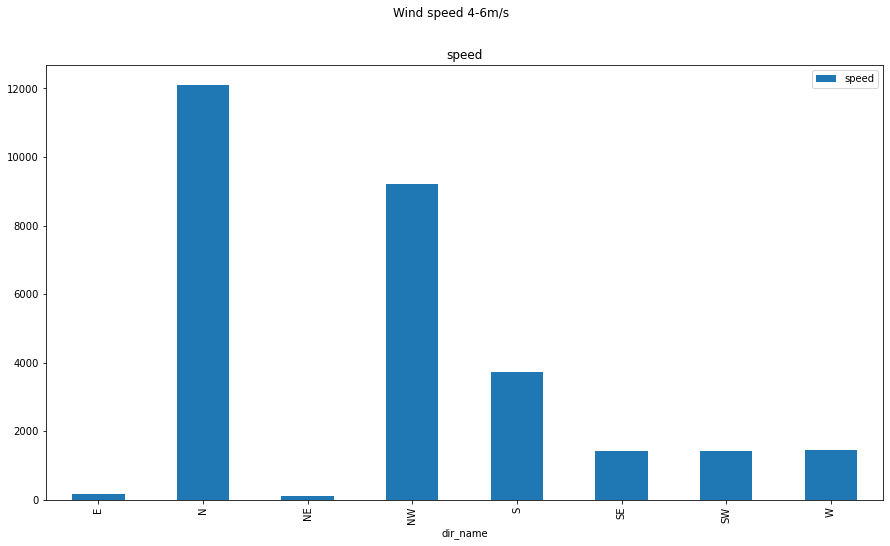

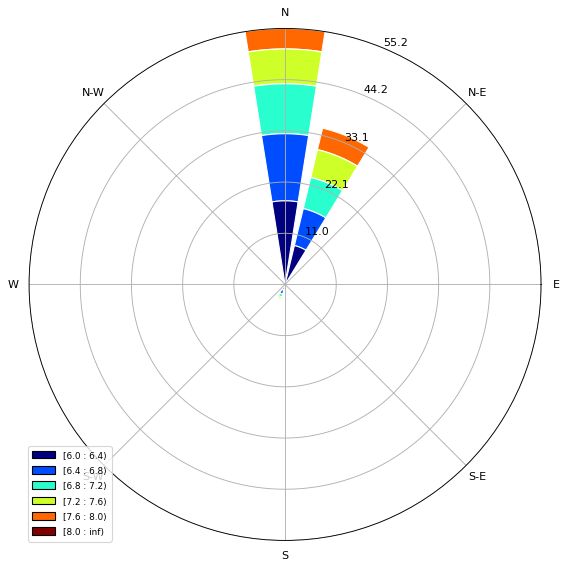

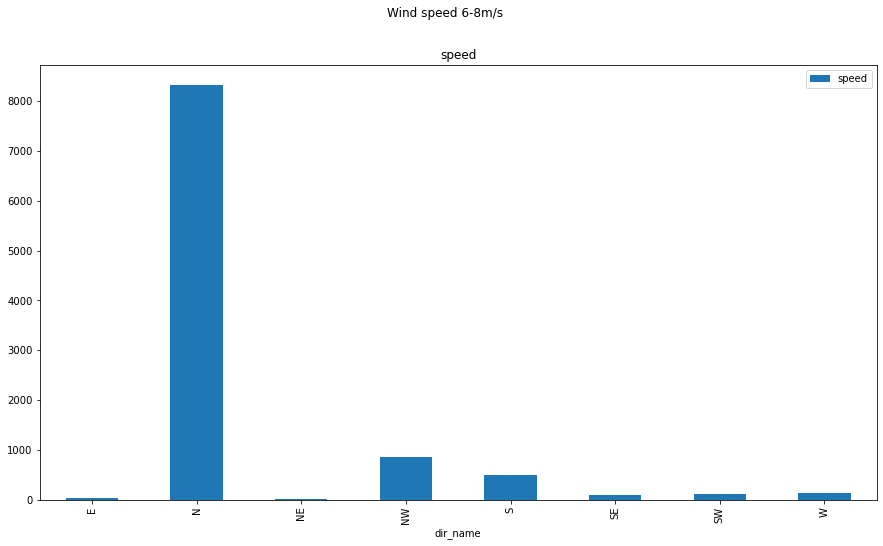

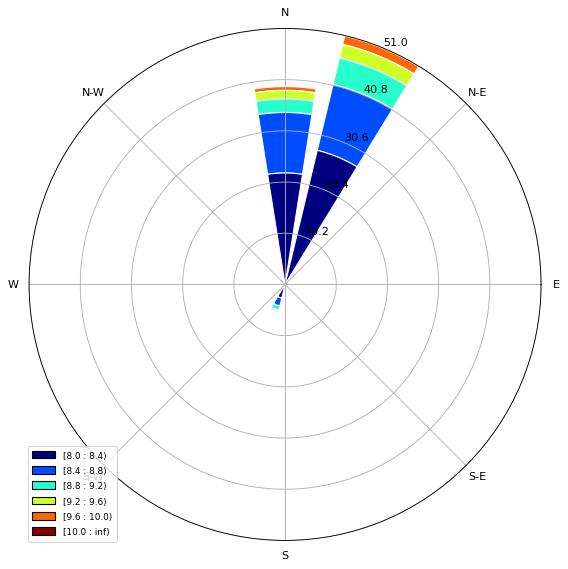

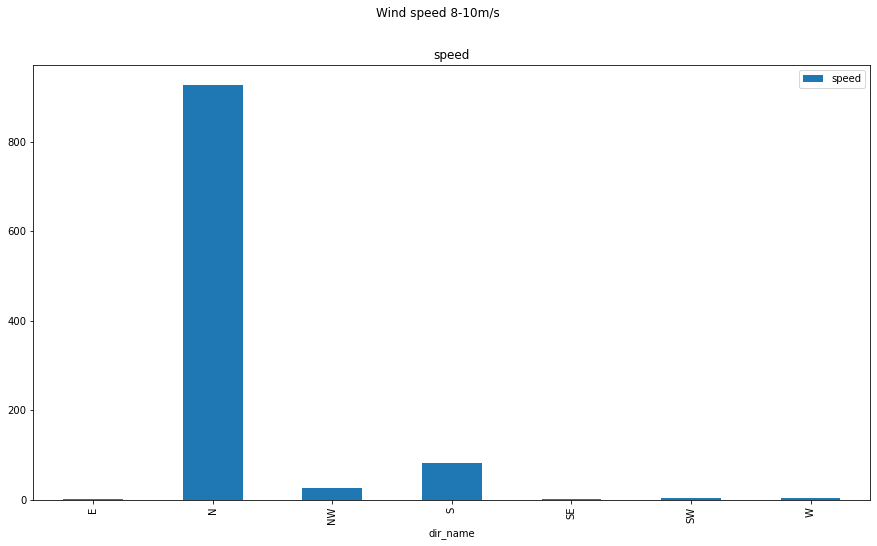

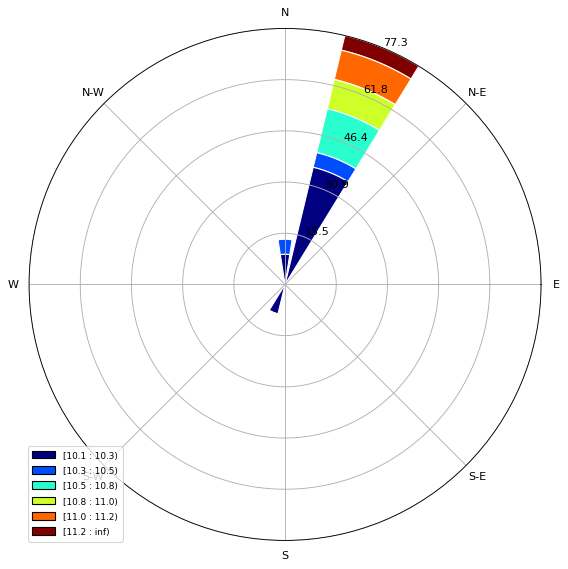

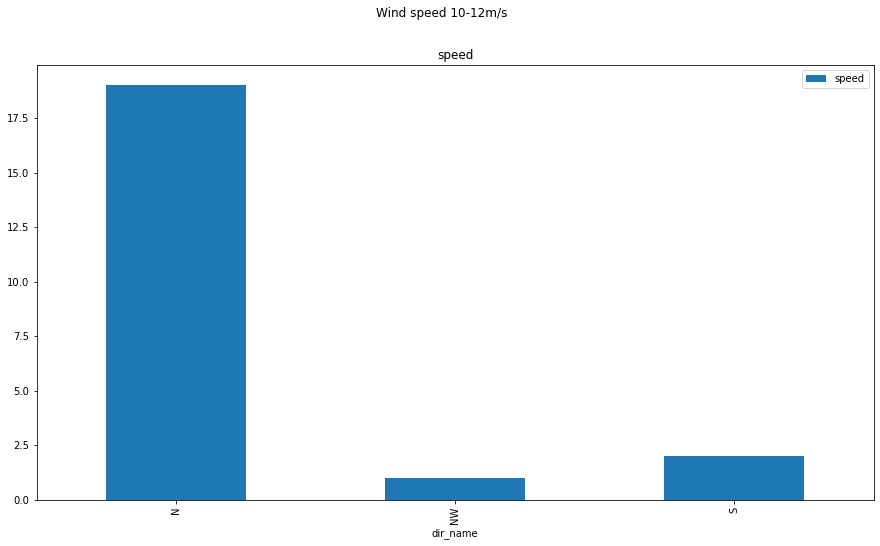

In [104]:
for i in range (0,12,2):
    df_sd0 = df_sd[(df_sd.speed>i) & (df_sd.speed<=i+2)].reset_index().drop(columns='index')
    wind_rose(df_sd0)
    df_plot = df_sd0[['dir_name','speed']].groupby('dir_name').count()
    df_plot.plot.bar(title = 'Wind speed '+str(i)+'-'+str(i+2)+ 'm/s',subplots=True,figsize=(15,8))
    plt.savefig('/home/sgirtsou/Documents/vravrona/plots/ba_'+str(i)+'.pdf')

# PDF distribution

In [111]:
df_sd

,speed,direction,dir_name
1,4.548971,356.316988,NW
2,3.013476,342.743120,NW
3,2.059265,352.797206,NW
4,1.275891,134.000863,E
5,1.949676,293.695366,W
...,...,...,...
156283,1.772023,307.909141,W
156284,1.582381,270.559690,W
156285,0.915472,219.955234,S
156286,0.259715,88.279590,NE


/home/aapostolakis/miniconda3/envs/ffp/lib/python3.6/site-packages/windrose/windrose.py:694: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist, bins = np.histogram(var, bins=bins, normed=True)


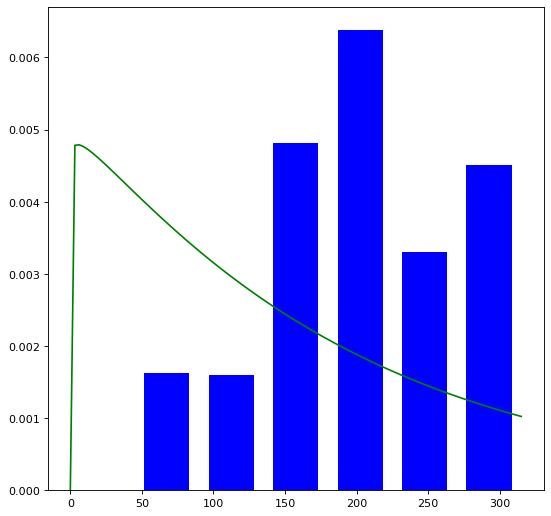

In [116]:
from windrose import WindAxes
ax = WindAxes.from_ax()
bins = np.arange(0, 360, 45)
bins = bins[1:]
ax, params = ax.pdf(df_sd.direction, bins=bins)

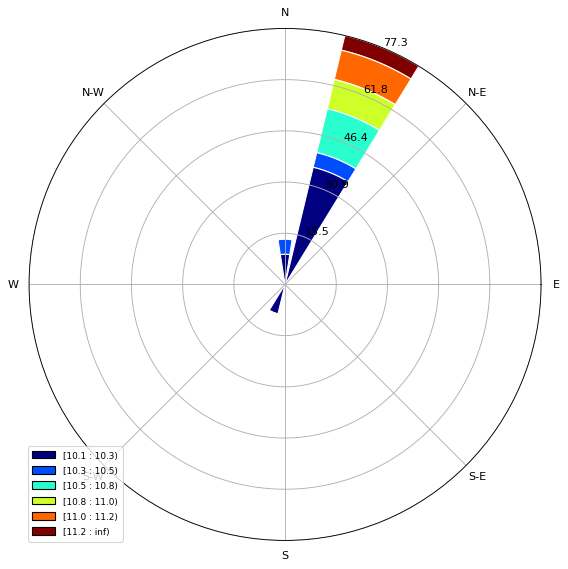

In [99]:
wind_rose(df_sd0)

In [16]:
wind_dir_groups = df_bins[['direction','speed']].groupby('direction').agg({'speed': ['mean', 'min', 'max']}) 

NameError: name 'df_bins' is not defined

In [15]:
df_time = df.reset_index()

NameError: name 'df' is not defined

In [14]:
df_time.plot(figsize=(15,4))
df.plot(subplots=True, figsize=(15,6))
df_time.plot(y=["R", "F10.7"], figsize=(15,4))
df_time.plot(x="R", y=["F10.7", "Dst"], style='.')

NameError: name 'df_time' is not defined

In [14]:
df_bins

NameError: name 'df_bins' is not defined

In [156]:
df_sd[df_sd.direction == 2].angle.describe()

count    10769.000000
mean        38.136359
std         12.591542
min         22.501667
25%         27.370316
50%         34.693140
75%         47.199360
max         67.483400
Name: angle, dtype: float64